In [ ]:
from langgraph.graph.state import StateGraph
from typing import TypedDict, Literal, Annotated
from langgraph.graph.message import BaseMessage, add_messages
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.checkpoint.postgres import PostgresSaver #for production

from euriai.langchain import create_chat_model
from dotenv import load_dotenv
import os
load_dotenv()
_euron_llm_key = os.getenv("EURON_KEY")

LLM Chat Model

In [2]:
def get_llm_model(llm_key =_euron_llm_key, model_id="gpt-4.1-nano", temp = 0.6):
     model = create_chat_model(api_key= llm_key, model=model_id, temperature= temp)
     return model



In [3]:
model1 = model = get_llm_model()
model1.invoke("who are you?")

AIMessage(content='Hello! I am an AI language model developed to assist with your questions and provide information. How can I help you today?', additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 13, 'completion_tokens': 25, 'total_tokens': 38}, 'model_name': 'gpt-4.1-nano', 'system_fingerprint': None, 'finish_reason': 'stop', 'model': 'gpt-4.1-nano', 'created': 1768038357}, id='lc_run--019ba74c-54d1-7783-9eb5-bbdad1e16b85-0', usage_metadata={'input_tokens': 13, 'output_tokens': 25, 'total_tokens': 38})

Graph Starts here

In [4]:
class MyStateSchema(TypedDict):

    messages: Annotated[list[BaseMessage], add_messages]

In [5]:
model = get_llm_model()

def chat_node(state: MyStateSchema):

    #take user query from state i.e first and only message in state 
    query = state["messages"]
    
    #send the query to chat model
    resp = model.invoke(query)

    #response store
    return {"messages": [resp]}
     

In [6]:
model.invoke("hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 10, 'completion_tokens': 9, 'total_tokens': 19}, 'model_name': 'gpt-4.1-nano', 'system_fingerprint': None, 'finish_reason': 'stop', 'model': 'gpt-4.1-nano', 'created': 1768038359}, id='lc_run--019ba74c-5bed-72d2-90fa-11ccaff5d92d-0', usage_metadata={'input_tokens': 10, 'output_tokens': 9, 'total_tokens': 19})

In [ ]:
from langgraph.graph import START, END

graph = StateGraph(MyStateSchema)
checkpointer_obj = InMemorySaver()

graph.add_node("cn", chat_node)
graph.add_edge(START, "cn")
graph.add_edge("cn", END)

workflow = graph.compile(checkpointer= checkpointer_obj)


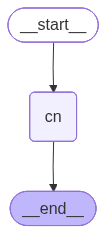

In [8]:
from IPython.display import Image, display

display(Image(workflow.get_graph().draw_mermaid_png()))

One time conversation chat bot

In [9]:
# obj = HumanMessage(content="hola amigo")

# initial_state = {
#     'messages': [obj]
# }

# result = workflow.invoke(initial_state)
# print(result['messages'][-1].content)

conversation in loop with a memory that remembers the conversation

In [10]:

stop_words = ['bye', 'stop', 'exit']

thread_id = '1'



while True:

    user_input = input("YOU: ").strip()

    print('YOU: ', user_input)

    if user_input in stop_words:
        break

    my_chat_state = {
        'messages': HumanMessage(content=user_input)
        }
    
    config = {
    'configurable': {
        'thread_id': thread_id
        }
    }   

    resp = workflow.invoke(my_chat_state, config=config)

    print('AI:' , resp['messages'][-1].content)

    


YOU:  my namw is akak
AI: Hello, Akak! Nice to meet you. How can I assist you today?
YOU:  what is my name?
AI: Hello! Your name is Akak. How can I help you today?
YOU:  what is 3+9
AI: 3 + 9 equals 12.
YOU:  now add 2 to the last result
AI: 12 + 2 equals 14.
YOU:  exit
